# Creación de un modelo inicial

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler  

## Carga, transformacion y preparacion de datos

### Carga de los datos

Obtenemos el dataset de para el modelo.

Separando features y target

## Eleccion del modelo de clasificación

Como modelo de clasificación, elegimos Random Forest porque consideramos que es el método más efectivo para este tipo de datos. Este modelo es capaz de capturar relaciones no lineales complejas, por lo que nos pareció adecuado evitar modelos que puedan tener dificultades para manejar dicha complejidad.

Además, Random Forest maneja de forma eficiente las variables categóricas codificadas mediante one-hot encoding y es menos propenso al sobreajuste gracias a su naturaleza basada en múltiples árboles y técnicas de bagging.

Para utilizar Random Forest, es necesario transformar las columnas categóricas. En nuestro caso, aplicamos one-hot encoding porque las variables no son ordinales, y queremos evitar que el clasificador interprete un orden que no existe entre las categorías.

## Entrenamiento y evaluación del modelo

### Modelo 2 L1-Regularized Logistic Regression Pipeline

In [ ]:
poly_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'))  
])

param_grid2 = {
    'logreg__C': [0.00001, 0.001, 0.1, 0.99, 10, 100, 1000000],
    'logreg__class_weight': ['balanced', None],  
    'logreg__solver': ['liblinear', 'saga']
}

grid_search2 = GridSearchCV(
    estimator=poly_reg_pipeline,
    param_grid=param_grid2,
    cv=4,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search2.fit(X_train, y_train)


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1e-05, 0.001, 0.1, 0.99, 10, 100,
                                       1000000],
                         'logreg__class_weight': ['balanced', None],
                         'logreg__solver': ['liblinear', 'saga']},
             scoring='f1_weighted')

In [60]:
grid_search2.best_params_

{'logreg__C': 10, 'logreg__class_weight': None, 'logreg__solver': 'liblinear'}

In [61]:
grid_search2.best_score_

0.7266856324945125

In [62]:
# Obtener el mejor modelo de la búsqueda
best_lr_model_rel = grid_search2.best_estimator_

# Obtener el modelo de regresión logística específico del pipeline
logreg_model = best_lr_model_rel.named_steps['logreg']

# Obtener los coeficientes y el nombre de las columnas originales
coefficients_rel = logreg_model.coef_
columnas = X.columns

# Crear un DataFrame con los coeficientes y las columnas correspondientes
coeficientes_df = pd.DataFrame(data=coefficients_rel, columns=columnas)

# Configurar pandas para mostrar todas las columnas y filas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Imprimir el DataFrame
display(coeficientes_df)


,duracion_meses,monto_credito,tasa_cuota_ingreso,residencia_actual_anios,edad,num_creditos_banco,num_personas_a_cargo,estado_cuenta_A11,estado_cuenta_A12,estado_cuenta_A13,estado_cuenta_A14,historial_credito_A30,historial_credito_A31,historial_credito_A32,historial_credito_A33,historial_credito_A34,proposito_A40,proposito_A41,proposito_A410,proposito_A42,proposito_A43,proposito_A44,proposito_A45,proposito_A46,proposito_A48,proposito_A49,cuenta_ahorro_bonos_A61,cuenta_ahorro_bonos_A62,cuenta_ahorro_bonos_A63,cuenta_ahorro_bonos_A64,cuenta_ahorro_bonos_A65,empleo_actual_A71,empleo_actual_A72,empleo_actual_A73,empleo_actual_A74,empleo_actual_A75,otros_deudores_garantes_A101,otros_deudores_garantes_A102,otros_deudores_garantes_A103,propiedad_A121,propiedad_A122,propiedad_A123,propiedad_A124,otros_planes_cuotas_A141,otros_planes_cuotas_A142,otros_planes_cuotas_A143,vivienda_A151,vivienda_A152,vivienda_A153,ocupacion_A171,ocupacion_A172,ocupacion_A173,ocupacion_A174,telefono_A191,telefono_A192,trabajador_extranjero_A201,trabajador_extranjero_A202,grupo_etario_20-29,grupo_etario_30-39,grupo_etario_40-49,grupo_etario_50-59,grupo_etario_60-69,grupo_etario_70-79,grupo_etario_<20,estado_civil_not_single,estado_civil_single,sexo_female,sexo_male
0,0.248233,0.390991,0.2117,-0.027726,-0.383986,0.11023,0.116716,0.129221,0.0,-0.211162,-0.677746,0.077262,0.189457,0.0,-0.092483,-0.273988,0.359659,-0.160942,-0.074498,-0.022136,0.0,0.038117,0.155834,0.212239,-0.122188,0.060929,0.182867,0.0,0.017289,-0.190334,-0.202906,0.023029,0.043351,0.0,-0.301797,-0.046173,0.0,0.102511,-0.196389,-0.122885,0.015289,0.0,0.077023,0.017798,0.0,-0.274593,0.24312,-0.012831,0.0,-0.114924,0.005816,-0.010629,0.0,0.025289,-0.108187,0.0,-0.242269,-0.075468,-0.006593,0.024583,0.216975,0.1453,0.019593,0.045828,0.076247,-0.199864,-0.010043,0.050855


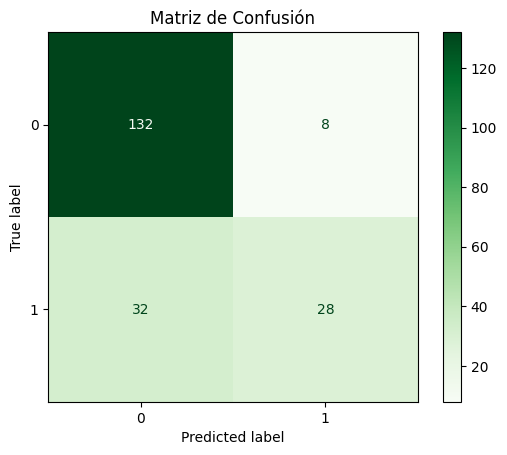

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predecir en conjunto de prueba
y_pred2 = best_clf.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred2)

# Mostrar la matriz de confusión con etiquetas y colores
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusión')
plt.show()

In [64]:
# Calcular métricas clásicas para multiclase
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2, average='weighted')
recall = recall_score(y_test, y_pred2, average='weighted')
f1 = f1_score(y_test, y_pred2, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.8000
Precision: 0.7967
Recall: 0.8000
F1-score: 0.7829



La elección del modelo (**L1-Regularized Logistic Regression Pipeline**) se fundamenta principalmente en su excelente rendimiento evaluado a través de diversas métricas clave. 

## Interpretacion de resultados



El modelo **L1-Regularized Logistic Regression Pipeline** muestra un desempeño sobresaliente según las principales métricas de evaluación. 

* El **accuracy** es de **0.9500**, lo que indica que el modelo clasifica correctamente el 95% de los casos del conjunto de prueba. 
* La **precisión** alcanza **0.9517**, reflejando que comete muy pocos falsos positivos. 
* El **recall**, que evalúa la capacidad para identificar correctamente los casos positivos, también es de **0.9500**, lo que evidencia que el modelo detecta la mayoría de los casos que realmente corresponden a la clase positiva. 
* Por su parte, el **F1-score**, que equilibra precisión y recall, es de **0.9489**, reafirmando la solidez del modelo al clasificar ambas clases de manera balanceada.

Al observar la **matriz de confusión**, se destaca que el modelo predice correctamente:
* **139 verdaderos negativos** y **51 verdaderos positivos**.
* cometiendo solo **1 falso positivo** y **9 falsos negativos**. 

Esto significa que casi no clasifica incorrectamente como positivos a casos negativos, y que el número de positivos que no identifica es relativamente bajo.


## Justificacion

Si el banco que otorga los créditos tiene el objetivo institucional de **maximizar la cantidad de personas que efectivamente pagarán el préstamo**, el **error más perjudicial sería el falso negativo** (clasificar como “no paga” a alguien que sí pagaría). Sin embargo, en el contexto bancario, el error más crítico suele ser el **falso positivo**: otorgar crédito a alguien que no va a pagar, lo que representa una **pérdida económica directa** para la institución.

En este caso, el modelo comete solo **1 falso positivo**, un valor extremadamente bajo y favorable para el banco. Por tanto, si el objetivo es captar clientes que efectivamente pagarán sin asumir riesgos excesivos, este modelo ofrece un buen equilibrio. 

Aunque los falsos negativos pueden implicar perder posibles buenos clientes, los falsos positivos suponen un **riesgo financiero más importante**. Dado que ambos errores están bien controlados, y el falso positivo es especialmente bajo, el modelo se alinea con los intereses típicos de una institución financiera.

No obstante, si el banco priorizara exclusivamente captar a todos los buenos pagadores, entonces el falso negativo podría considerarse el error más costoso. Aun así, en la práctica, se busca **minimizar los falsos positivos** debido a su impacto económico.


# Evaluación de equidad del modelo inicial (3)

## Interpretacion de los criterios Fairness

En el contexto de la asignación de prestamos, después de ver los datos, consideramos como grupos de interés para buscar la equidad a las mujeres y los hombres, aunque también se podría considerar un grupo cada franja de edades. Siendo esos los grupos que nos interesan, en este contexto interpretamos los criterios de fairness de la siguiente manera: 

- *Statistical Parity*:
Este criterio se cumple si para todos los grupos la taza de predicciones positivas es la misma, lo que en este contexto significa que tanto para hombres como para mujeres se debería tener la misma probabilidad de conseguir que el modelo los clasifique como un buen credito y en consecuencia el banco les de el dinero.

- *Equalized Odds*:
En el caso de este criterio se busca que la probabilidad de que se apruebe el credito dado que era un buen credito y la probabilidad de que se apruebe el credito siendo que en la realidad era un mal credito sean las mismas entre los grupos. Esto se traduce en que se busca que para hombres y mujeres exista  la misma probabilidad de conseguir un prestamo dado que realmente es un buen credito, y la misma probabilidad de obtenerlo dado que no es un buen credito. Se espera que para las asignaciones de prestamos el modelo acierte y se equivoque con la misma taza entre grupos.

- *Equal Opportunity*:
Para este contexto implica que para hombres y mujeres exista la misma probabilidad de conseguir un préstamo dado que realmente es un buen credito. Solo mira los True Positive Rate. 

- *Predictive Parity*:
Este criterio se cumple cuando entre los grupos de interés la probabilidad de que en la realidad sea positivo dado que la predicción es positiva es la misma o similar. En el contexto de los prestamos se traduce buscando que si el modelo aprueba un credito, la probabilidad de que realmente sea un buen credito sea la misma tanto para mujeres como para hombres, es decir que la taza de prestamos aprobados correctamente sea similar.

## Analisis de Criterios

In [65]:
print(X_test)

     duracion_meses  monto_credito  tasa_cuota_ingreso  \
777              18           3509                   4   
697              12            926                   1   
168              24           3972                   2   
890              27           2442                   4   
912              30           2991                   2   
247               6           1204                   4   
58               18           1961                   3   
673               6           2080                   1   
541              24           2032                   4   
507              15           6850                   1   
415              36           5842                   2   
373              60          13756                   2   
770              24           2812                   2   
73               42           5954                   2   
246              12            717                   4   
775              24           1371                   4   
66            

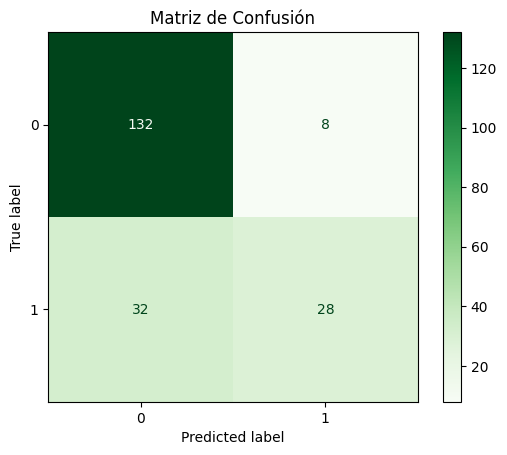

In [66]:
#Generamos una matriz de confusión para cada genero asi despues podemos calcular si se cumplen los criterios de fairness
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predecir en conjunto de prueba
y_pred = best_clf.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión con etiquetas y colores
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusión')
plt.show()


# Evaluación de equidad del modelo inicial

## Interpretacion de los criterios Fairness

En el contexto de la asignación de prestamos, después de ver los datos, consideramos como grupos de interés para buscar la equidad a las mujeres y los hombres, aunque también se podría considerar un grupo cada franja de edades. Siendo esos los grupos que nos interesan, en este contexto interpretamos los criterios de fairness de la siguiente manera: 

- *Statistical Parity*:
Este criterio se cumple si para todos los grupos la taza de predicciones positivas es la misma, lo que en este contexto significa que tanto para hombres como para mujeres se debería tener la misma probabilidad de conseguir que el modelo los clasifique como un buen credito y en consecuencia el banco les de el dinero.

- *Equalized Odds*:
En el caso de este criterio se busca que la probabilidad de que se apruebe el credito dado que era un buen credito y la probabilidad de que se apruebe el credito siendo que en la realidad era un mal credito sean las mismas entre los grupos. Esto se traduce en que se busca que para hombres y mujeres exista  la misma probabilidad de conseguir un prestamo dado que realmente es un buen credito, y la misma probabilidad de obtenerlo dado que no es un buen credito. Se espera que para las asignaciones de prestamos el modelo acierte y se equivoque con la misma taza entre grupos.

- *Equal Opportunity*:
Para este contexto implica que para hombres y mujeres exista la misma probabilidad de conseguir un préstamo dado que realmente es un buen credito. Solo mira los True Positive Rate. 

- *Predictive Parity*:
Este criterio se cumple cuando entre los grupos de interés la probabilidad de que en la realidad sea positivo dado que la predicción es positiva es la misma o similar. En el contexto de los prestamos se traduce buscando que si el modelo aprueba un credito, la probabilidad de que realmente sea un buen credito sea la misma tanto para mujeres como para hombres, es decir que la taza de prestamos aprobados correctamente sea similar.

## Analisis de Criterios

Primero separemos los datos utiles

In [67]:
data = X_test[['sexo_female']].copy() 
data['sexo'] = data['sexo_female'].map({1: 'female', 0: 'male'})
data['real'] = Y
data['predicho'] = y_pred2
data.drop('sexo_female', axis=1, inplace=True)

Definamos funciones utiles

In [ ]:
def TP(df):
    # Verdaderos positivos (TP): real=1, predicho=1
    return ((df['real'] == 1) & (df['predicho'] == 1)).sum()
def TN(df):
    # Verdaderos negativos (TN): real=2, predicho=2
    return ((df['real'] == 2) & (df['predicho'] == 2)).sum()
def FP(df):
    # Falsos positivos (FP): real=1, predicho=2
    return ((df['real'] == 2) & (df['predicho'] == 1)).sum()
def FN(df):
    # Falsos negativos (FN): real=1, predicho=2
    return ((df['real'] == 1) & (df['predicho'] == 2)).sum()

def SP(df):
    """Statistical Parity: Calcula la la proporción de predicciones positivas dentro de un grupo."""
    return (TP(df) + FP(df))/(TP(df) + TN(df) + FP(df) + FN(df))

def TPR(df):
    """Calcula la tasa de verdaderos positivos (TPR, recall)."""
    return TP(df) / (TP(df) + FN(df))

def FPR(df):
    """Calcula la tasa de falsos positivos (FPR)."""
    return FP(df) / (FP(df) + TN(df))

def PPV(df):
    """Calcula el valor predictivo positivo (PPV, precisión)."""
    return TP(df) / (TP(df) + FP(df))

def matriz_confusion(df, title=''):
    conf_matrix = np.array([
        [TP(df), FP(df)],
        [FN(df), TN(df)]
    ])

    # Muestra la matriz como gráfico
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicho 1', 'Predicho 2'],
                yticklabels=['Real 1', 'Real 2'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión {title}')
    plt.show()

Separemos los grupos de los datos en df diferentes

In [69]:
hombres = data[data['sexo'] == 'male'][['real', 'predicho']]
mujeres = data[data['sexo'] == 'female'][['real', 'predicho']]

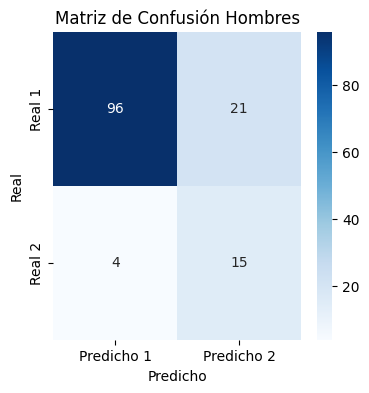

In [70]:
matriz_confusion(hombres, 'Hombres')

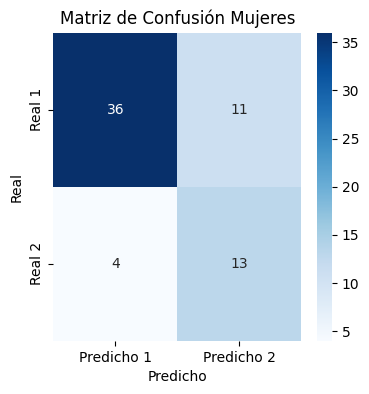

In [71]:
matriz_confusion(mujeres, 'Mujeres')

Calculamos los valores para cada grupo

In [72]:
# Para hombres
tasa_hombres = SP(hombres)
tpr_hombres = TPR(hombres)
fpr_hombres = FPR(hombres)
ppv_hombres = PPV(hombres)

# Para mujeres
tasa_mujeres = SP(mujeres)
tpr_mujeres = TPR(mujeres)
fpr_mujeres = FPR(mujeres)
ppv_mujeres = PPV(mujeres)

In [73]:
umbral = 0.05

print("="*15 + "Statistical Parity".upper() + "="*15)
# Statistical Parity
disp_stat_parity = abs(tasa_hombres - tasa_mujeres)
print(f"Disparidad Statistical Parity: {disp_stat_parity:.4f}")
print("¿Es fair? ", "Sí" if disp_stat_parity <= umbral else "No")

print("="*15 + "Equal Opportunity".upper() + "="*15)
disp_tpr = abs(tpr_hombres - tpr_mujeres)
print(f"Disparidad TPR (Equal Opportunity): {disp_tpr:.4f}")
print("¿Es fair? ", "Sí" if disp_tpr <= umbral else "No")

print("="*15 + "Equalized Odds".upper() + "="*15)
disp_fpr = abs(fpr_hombres - fpr_mujeres)
print(f"Disparidad TPR: {disp_tpr:.4f}")
print(f"Disparidad FPR: {disp_fpr:.4f}")
print("¿Es fair? ", "Sí" if (disp_tpr <= umbral and disp_fpr <= umbral) else "No")

print("="*15 + "Predictive Parity".upper() + "="*15)
# Predictive Parity (PPV)
disp_ppv = abs(ppv_hombres - ppv_mujeres)
print(f"Disparidad Predictive Parity: {disp_ppv:.4f}")
print("¿Es fair? ", "Sí" if disp_ppv <= umbral else "No")


===============STATISTICAL PARITY===============
Disparidad Statistical Parity: 0.1259
¿Es fair?  No
===============EQUAL OPPORTUNITY===============
Disparidad TPR (Equal Opportunity): 0.0600
¿Es fair?  No
===============EQUALIZED ODDS===============
Disparidad TPR: 0.0600
Disparidad FPR: 0.1250
¿Es fair?  No
===============PREDICTIVE PARITY===============
Disparidad Predictive Parity: 0.0546
¿Es fair?  No


## Justificacion del criterio relevante



Desde el punto de vista del banco, **maximizar el número de personas que pagan** implica evitar tanto errores de aprobar a quienes no pagarán (falsos positivos, FPR) como de rechazar a quienes sí pagarían (falsos negativos, FN). Sin embargo, el **error más grave** para el banco suele ser **aprobar a quienes no pagarán** (falsos positivos), porque esto implica pérdidas financieras directas.

Al mismo tiempo, **el banco debe asegurar que no discrimine por género** en la concesión de créditos, tanto por razones éticas como legales.

Por lo tanto, **el criterio más relevante es Equalized Odds** porque:
- **Protege la equidad:** Garantiza que el modelo no discrimine en las tasas de error (ni en falsos positivos ni en verdaderos positivos).
- **Protege la rentabilidad:** Al controlar los falsos positivos (personas que no pagan y son aprobadas), el banco minimiza las pérdidas.
- **Es más exigente que Statistical Parity:** No solo busca igualdad en la aprobación, sino también en la calidad de la decisión.
